# Does title length affect ratings?
**Steven Zych**

This document explores the relationships between a films title length (in words) and its average ratings as well as average number of ratings. It will be shown that **yes, a meaningful relationship exists.**

## Importing Data

First we import our main libraries and open all those .csv files as DataFrames.

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This pulls all the .csv files into one list of dataframes.

csv_files = glob('zippedData/*.csv.gz')
csv_dfs = [pd.read_csv(f) for f in csv_files]
len(csv_dfs)

9

Now we give those files readable names and open them to see what meaningful columns we want to work with.

In [3]:
# Assign the .csv files to human-readable variables.
imdb_basics = csv_dfs[3]
imdb_ratings = csv_dfs[6]

In [4]:
imdb_basics.head() # Using: tconst, primary_title, start_year

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
imdb_ratings.head() #Using: tconst, averagerating, numvotes

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Establishing A Database

Then, we create a SQL database, check that it's in our working directory, and import our DataFrames into SQL.

In [6]:
# Create a SQL database for easy joins.

conn = sqlite3.connect('steven2.db')
cur = conn.cursor()

In [7]:
# Check to make sure SQL database was created.

In [8]:
ls

 Volume in drive C is OS
 Volume Serial Number is C084-E836

 Directory of C:\Users\Steven\class\mod1\movie-analysis

06/18/2020  03:45 PM    <DIR>          .
06/18/2020  03:45 PM    <DIR>          ..
06/16/2020  11:59 AM             2,131 .gitignore
06/18/2020  11:42 AM    <DIR>          .ipynb_checkpoints
06/17/2020  10:59 AM            44,093 profit_and_runtime_cleaning.ipynb
06/18/2020  02:30 PM           135,935 profit_and_runtime_plotting.ipynb
06/16/2020  10:26 AM                16 README.md
06/18/2020  03:45 PM           163,145 steven_average_rating_and_title_length.ipynb
06/16/2020  11:49 AM            61,933 steven_data_exploration.ipynb
06/18/2020  01:47 PM        12,980,224 steven2.db
06/16/2020  03:28 PM    <DIR>          zippedData
               7 File(s)     13,387,477 bytes
               4 Dir(s)  45,830,942,720 bytes free


In [9]:
# Turn dataframes into tables on database.

imdb_basics.to_sql('basics', conn, if_exists='replace', index=False)
imdb_ratings.to_sql('ratings', conn, if_exists='replace', index=False)

In [10]:
# Commit database changes

conn.commit()

In [11]:
a = pd.DataFrame(cur.execute("""SELECT b.primary_title, b.start_year, b.tconst, r.numvotes, r.averagerating
                                FROM basics b
                                JOIN ratings r
                                USING(tconst)""").fetchall())
a.columns = [x[0] for x in cur.description]
basic_rating = a.set_index('tconst')
basic_rating

,primary_title,start_year,numvotes,averagerating
tconst,,,,
tt0063540,Sunghursh,2013,77,7.0
tt0066787,One Day Before the Rainy Season,2019,43,7.2
tt0069049,The Other Side of the Wind,2018,4517,6.9
tt0069204,Sabse Bada Sukh,2018,13,6.1
tt0100275,The Wandering Soap Opera,2017,119,6.5
...,...,...,...,...
tt9913084,Diabolik sono io,2019,6,6.2
tt9914286,Sokagin Çocuklari,2019,136,8.7
tt9914642,Albatross,2017,8,8.5


Above, we've joined the two DataFrames we were interested in. We now have all the key columns necessary to address our research question.

## Feature-Engineering Title Length

Now, we're going to refine this DataFrame a bit more. We don't want data from movies with too few votes, so let's drop anything with less than 100 and see where that leaves us.

In [12]:
# We pass the DataFrame a Pandas series of booleans.
# True values have 100+ votes and are kept.

enough_votes = basic_rating.numvotes >= 100
br2 = basic_rating[enough_votes]
br2.head()

,primary_title,start_year,numvotes,averagerating
tconst,,,,
tt0069049,The Other Side of the Wind,2018,4517,6.9
tt0100275,The Wandering Soap Opera,2017,119,6.5
tt0137204,Joe Finds Grace,2017,263,8.1
tt0146592,Pál Adrienn,2010,451,6.8
tt0162942,Children of the Green Dragon,2010,120,6.9


Great! We still have a lot of data to work with, and have gotten rid of anything where there's not enough ratings to really be salient. But now we need to add a new column for title length. We'll be looking at number of words as opposed to number of letters. (This decision was made because the English syllabary is awfully messy and inconsistent in its average length. For example, a single syllable word can be as short as "a" or as long as "strength." For this reason, whole words are a more reliable metric.)

In [13]:
# Make an empty list to hold title lengths.
# Make another list, that contains all the split titles in our DataFrame.
# Use a for loop to populate the first list with the word-lengths of these titles.

title_lengths = []
split_titles = br2['primary_title'].str.split()
for i in range(0,28753):
    title_lengths.append(len(split_titles[i]))

In [14]:
# Check that it works

title_lengths[:5]

[6, 4, 3, 2, 5]

In [19]:
# Create a new column using our title length list

br2.loc[:,'title_length'] = title_lengths
br2

,primary_title,start_year,numvotes,averagerating,title_length
tconst,,,,,
tt0069049,The Other Side of the Wind,2018,4517,6.9,6
tt0100275,The Wandering Soap Opera,2017,119,6.5,4
tt0137204,Joe Finds Grace,2017,263,8.1,3
tt0146592,Pál Adrienn,2010,451,6.8,2
tt0162942,Children of the Green Dragon,2010,120,6.9,5
...,...,...,...,...,...
tt9904844,Ott Tänak: The Movie,2019,218,8.7,4
tt9905412,Ottam,2019,505,8.1,1
tt9905462,Pengalila,2019,600,8.4,1


Sweet, looks good! Our features are engineered and ready to be plotted.

# Plotting The Data
## Length And Average Rating

First we'll use a violin plot to show **distribution of average ratings in relation to title length.** As you can see from the graph below, the title length of a film has very little bearing on the shape its ratings will take. Aside from films with titles of 11 or more words (of which there are not many), the violins are nearly identical.

Note that the singular line at title length 16 is not an error, there is just only one movie in the database with that length title.

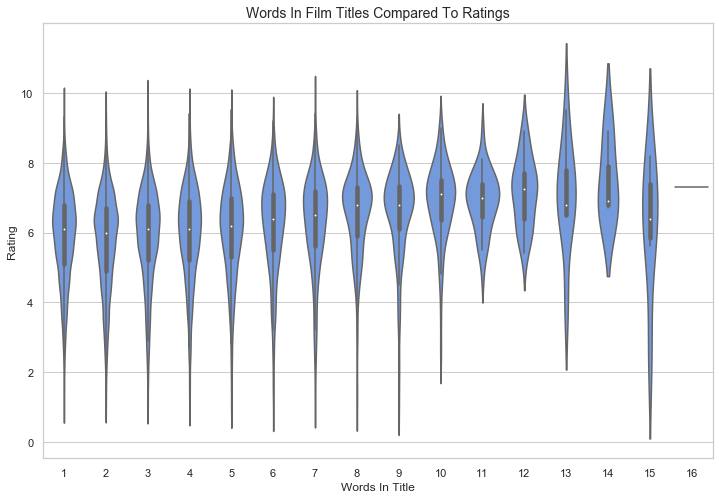

In [16]:
sns.set(style="whitegrid")
ax = plt.subplots(figsize=(12,8))
ax = sns.violinplot(x=br2['title_length'], y=br2['averagerating'], color='cornflowerblue')
ax.set(xlabel='Words In Title', ylabel='Rating')
ax.axes.set_title("Words In Film Titles Compared To Ratings",fontsize=14);

The plot below shows another angle of the same data, answering the question: **How many total ratings were submitted for all films of a certain title length?**

## Length And Total Number Of Ratings

This plot shows a shocking regularity resembling exponential decay from title length 2 to 16. Keep in mind though that this is more indicative of **how many films are being named these lengths** than **how often films of these lengths are being rated in the first place.** For this second point, we'll have to refer to the plot after this one.

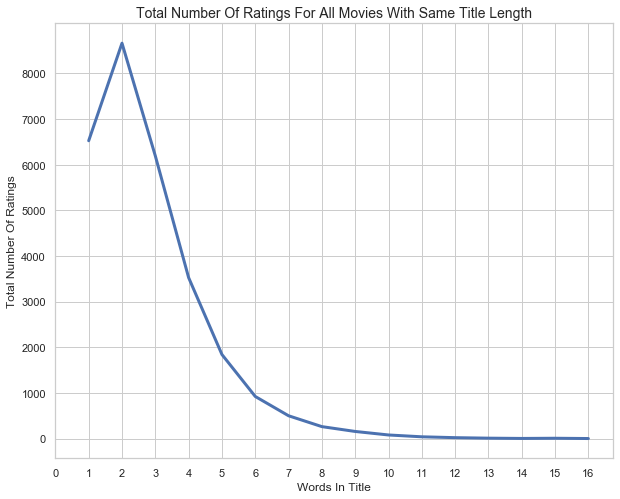

In [17]:
plt.subplots(figsize=(10,8))
plt.plot(br2['title_length'].value_counts().sort_index(), linewidth=3)
plt.xticks(ticks=(range(0,17)))
plt.yticks(np.arange(0, 9000, 1000))
plt.xlabel("Words In Title")
plt.ylabel("Total Number Of Ratings")
plt.title("Total Number Of Ratings For All Movies With Same Title Length",fontsize=14);

## Feature-Engineering Average Number Of Ratings For All Films Of Same Title Length

I believe this to be a more interesting metric than the previous, though the previous was necessary to get us here. **Obviously,** the y-value for "total number of ratings" for all films with any given title length will be proportional to the amount of films that typically have that-length names.

This metric, instead, **treats the title-length groups uniformly,** and answers the question: **Does one title-length group get reviewed more often PER FILM than any other group?**

In [32]:
# New list to hold total ratings for all films with same length

total_ratings_by_length = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(0,len(br2)):
    votes = br2['numvotes'][i]
    x = br2['title_length'][i]
    total_ratings_by_length[x] += votes

In [45]:
# Check that the list looks good. It does!
print(total_ratings_by_length)

[0, 64576317, 79132389, 50410027, 29589732, 18287981, 7579447, 4590349, 3946549, 541758, 253289, 72650, 20036, 2928, 1113, 6561, 198]


In [54]:
# Do the same as above but make a list of how many movies for each title length

total_films_w_length = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in range(0,len(br2)):
    x = br2['title_length'][i]
    total_films_w_length[x] += 1

In [55]:
# Check this list too. All good!
total_films_w_length

[0, 6526, 8664, 6195, 3527, 1842, 923, 500, 262, 156, 79, 39, 20, 9, 3, 7, 1]

In [60]:
# One last loop to make an average amount of ratings by title length

avg_amnt_ratings = []

for i in range(1,17):
    ratings = total_ratings_by_length[i]
    total = total_films_w_length[i]
    x = (ratings/total)
    avg_amnt_ratings.append(x)

In [62]:
# Check the last list. All good!
print(avg_amnt_ratings)

[9895.237051792828, 9133.470567867036, 8137.21178369653, 8389.490218315848, 9928.328447339847, 8211.751895991332, 9180.698, 15063.164122137405, 3472.8076923076924, 3206.1898734177216, 1862.820512820513, 1001.8, 325.3333333333333, 371.0, 937.2857142857143, 198.0]


## Plotting Average Number Of Ratings For All Films Of Same Title Length

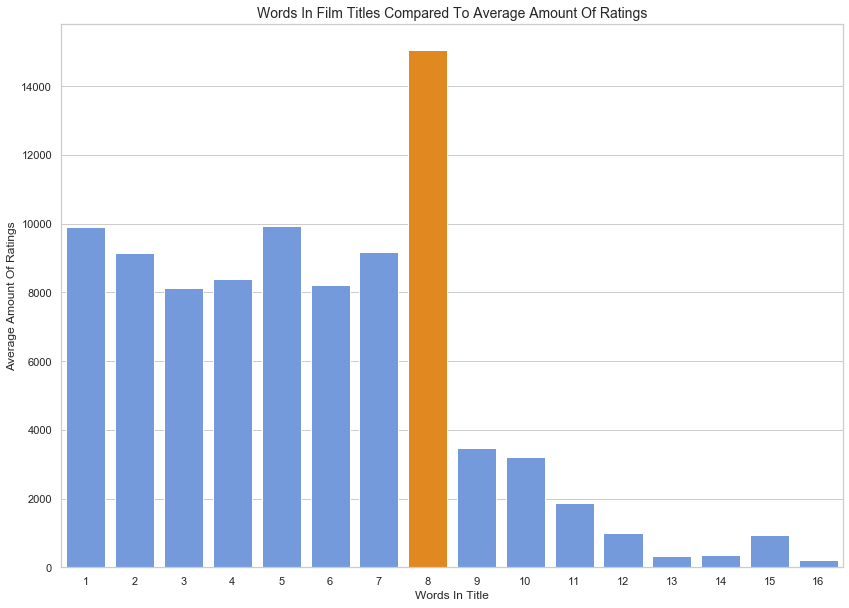

In [85]:
ax = plt.subplots(figsize=(14,10))
lengths = list(range(1,17))
colors = ["cornflowerblue" if (x < 10000) else 'darkorange' for x in avg_amnt_ratings] 
ax = sns.barplot(x=lengths, y=avg_amnt_ratings, palette=colors)                
ax.set(xlabel='Words In Title', ylabel='Average Amount Of Ratings')
ax.axes.set_title("Words In Film Titles Compared To Average Amount Of Ratings",fontsize=14);

As we can see from the plot above, title length **does** have a meaningful relationship with the amount of ratings a movie receives. In general, as title length increase, number of reviews decreases. But, there is an interesting outlier! Films with title length 8 are reviewed disproportionately more than any other group.

# Conclusion

Will making your movie's title a certain length make it better? Probably not.

But will its length have an effect on the amount of times it gets reviewed? Maybe. If your title is over eight words,tough luck--almost nobody reviews those movies. But give your movie an eight word title and you just might get lucky. Now, reviews aren't the **only** important metric, but visibility and public perception of a movie are still salient when it comes to determining long-term and repeat success (like with a franchise).

## Further Research

For further research I would like to delve into the relationships between title length and ROI, title length and budget (I have a sneaking suspicion Hollywood franchises hang out in the 1-8 word range), and the effect title length has in non-English markets.